# Markov Lokalisation

## Hintergrund

Die Markov Lokalisation ist ein Verfahren zur Lokalisation eines `Agent` in einer Umgebung. Die Umgebung ist durch eine Menge von Zuständen $x$ gegeben. Der `Agent` kann sich in dieser Umgebung bewegen und Messungen $z$ durchführen. Die Messungen sind nicht perfekt und können zu falschen Schlüssen führen. Die Bewegungen des `Agent` sind ebenfalls nicht perfekt und können zu unerwarteten Zustandsübergängen führen. Die Markov Lokalisation ist ein Verfahren, welches die Wahrscheinlichkeitsverteilung des Zustands des `Agent` schätzt.

> - $x_t$ ist der Zustand des `Agent` zum Zeitpunkt $t$
> - $u_t$ ist die Bewegung des `Agent` zum Zeitpunkt $t$
> - $z_t$ ist die Messung des `Agent` zum Zeitpunkt $t$
> - $b(x_t)$ ist die Wahrscheinlichkeitsverteilung des Zustands des `Agent` zum Zeitpunkt $t$
> - $p(a|b)$ ist die Wahrscheinlichkeit von $a$ gegeben $b$

Die Markov Lokalisation Algorithmus besteht aus zwei Schritten:

1. **Prediction**: Der `Agent` führt eine Bewegung durch. Die Wahrscheinlichkeitsverteilung des Zustands des `Agent` wird anhand der Bewegung geschätzt.

\begin{align*}
    b'(x_t) = \sum_{x_{t-1}} p(x_t | u_t, x_{t-1}) b(x_{t-1})
\end{align*}

2. **Update**: Der `Agent` führt eine Messung durch. Die Wahrscheinlichkeitsverteilung des Zustands des `Agent` wird anhand der Messung geschätzt.

\begin{align*}
    b(x_t) = \eta p(z_t | x_t) b'(x_t)
\end{align*}

Die Wahrscheinlichkeitsverteilung des Zustands des `Agent` wird iterativ geschätzt.


Die Hintergründe können ausführliche in folgendem [Buch](https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf) nachgelesen werden. Dort finden Sie auch weitere Beispiele für die Markov Lokalisation.

## Aufgabe

Ziel der Aufgabe ist die erfolgreiche Implementation der Markov Lokalisation.

Implementieren Sie die Klasse `Agent`, die die Methoden `p_x`, `p_z`, `predict` und `update` implementiert. Die `update` Methode soll die geglaubte State Wahrscheinlichkeitsverteilen $b(x_t)$ (`self.bel`) updaten. `self.bel` wird beim iterativen Aufruf von `Agent` verwendet um die Ergebnisse darzustellen.

### Zur Aufgabe:

Gegeben ist ein 1D Array der Länge `len`, auf welchem sich ein `Agent` nach rechts, links oder gar nicht bewegen kann. Es kann nach jedem Schritt eine Messung durchgeführt werden.

\begin{align*}
   z \in &\ \{ \texttt{wall}, \texttt{way} \} \\
   x \in &\ \mathbb{N}^{<\texttt{len}} \\
   u \in &\ [-1, 0, 1]
\end{align*}

#### Wahrscheinlichkeiten für die Messwerte:

> Den folgenden Term liest man wie folgt: Die Wahrscheinlichkeit, dass der Sensor $z$ den Wert `wall` hat, gegeben, dass der `Agent` sich an der Position $x=0$ befindet, beträgt $0.8$.
> 
> \begin{align*}
>    &&\     p(\texttt{wall} \mid x=0) &\ =\ 0.8 \\
> \end{align*}

\begin{align*}
   &&\     p(\texttt{wall} \mid x=0) &\ =\ 0.8 \\
   &&\     p(\texttt{way} \mid x=0) &\  =\ 0.2 \\
   &&\     p(\texttt{wall} \mid x=\texttt{len}-1) &\  =\ 0.8 \\
   &&\     p(\texttt{way} \mid x=\texttt{len}-1) &\  =\ 0.2 \\
   &&\     p(\texttt{wall} \mid 0 < x < \texttt{len}-1) &\  =\ 0.05 \\
   &&\     p(\texttt{way} \mid 0 < x < \texttt{len}-1) &\  =\ 0.95
\end{align*}

#### Die erlaubten Bewegungsmuster des `Agent`s:

- wenn er sich nicht am Rand des Arrays befindet, kann er sich in jede Richtung $u$ bewegen.
- wenn er sich am linken Rand befindet und nach links geht, verändert er die Position nicht
- wenn er sich am rechten Rand befindet und nach rechts geht, verändert er die Position nicht

Dieser Mechanismus ist duch folgende Wahrscheinlichkeitsverteilungen gegeben:

\begin{align*}
   &&\     p( x_t = x_{t-1} \mid  u_t = 0 ,\ 0 \leq x_{t-1} < \texttt{len})  &\ =\ 1 \\

   &&\     p( x_t = x_{t-1} \mid  u_t = -1 ,\ x_{t-1} = 0) &\  =\ 1 \\
   &&\     p( x_t = x_{t-1} \mid  u_t = 1 ,\ x_{t-1} = \texttt{len}-1) &\  =\ 1 \\

   &&\     p( x_t = x_{t-1}+1 \mid  u_t = 1 ,\ x_{t-1} < \texttt{len}-1) &\  =\ 1 \\
   &&\     p( x_t = x_{t-1}-1 \mid  u_t = -1 ,\ x_{t-1} > 0) &\  =\ 1 \\

\end{align*}

Für alle verbleibenden Konfigurationen von $x_t,\ u_t,\ x_{t-1}$ ist die Wahrscheinlichkeit null.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Folgendes ist das Environment, welches den Schritt entgegennimmt und Sensordaten zurückgibt.

**Sie dürfen nicht auf die `_pos` Eigenschaft zugreifen.**

In [2]:
class Environment:

    def __init__(self, size):
        self.arr = np.zeros(size)
        self.size = size
        self._pos = random.randint(0, size - 1)


    def step(self, u):
        if self._pos == 0 and u == -1 or self._pos == self.size - 1 and u == 1:
            return

        self._pos += u


    def sense(self):
        is_wall = self._pos == 0 or self._pos == self.size - 1

        if is_wall:
            return 'wall'
        else:
            return 'way'

In [3]:
class Agent:

    def __init__(self, env):
        self.env = env
        self.bel = [1 / env.size for _ in range(env.size)]
        self.u = [1, 0, -1]
        self.x = list(range(env.size))
        self.z = ['wall', 'way']
        self.last = env.size - 1


    def p_z(self, z, x):
        """
        properbility distribution of sensor data z for given position x

        :param z: str (Sensor data 'wall' or 'way')
        :param x: int (Position)
        :return: float (propability [0,1])
        """
        # TODO: your code here


    def p_x(self, x_next, x, u) -> int:
        """
        properbility distribution of x_t given control-action u_t and last position x_t-1

        :param x_next: int (next position)
        :param x: int (last position)
        :param u: int (control-action 0,1 or -1)
        :return: float (propability [0,1])
        """
        # TODO: your code here
        pass


    def predict(self, x_next, u) -> int:
        """
        Predicts the next belief state given the current belief state and the action

        :param x_next: the next state
        :param u: the action
        """
        # TODO: your code here
        pass


    def update(self, z, predicted_bel):
        """
        Updates the belief state given the current belief state and the observation

        :param z: the observation
        :param predicted_bel: the predicted belief state
        """
        # TODO: your code here
        pass


    def __iter__(self):
        self.steps = [0] + [random.choice(self.u)
                            for _ in range(self.num_steps - 1)]

        self.i = 0
        return self


    def __next__(self):
        if self.i < len(self.steps):

            u = self.steps[self.i]
            self.env.step(u)
            predicted_bel = [self.predict(x, u) for x in self.x]
            z = self.env.sense()
            self.update(z, predicted_bel)

            self.i += 1

            return self.bel, self.env._pos
        raise StopIteration


    def __call__(self, num_steps=9):
        self.num_steps = num_steps
        return self

In [4]:
class AgentVizualizer:

    def __init__(self, agent, num_steps=9):
        self.agent = agent
        self.num_steps = num_steps
        self.size = self.agent.env.size - 1


    def interpol_bel(self, bel):
        x = np.linspace(0, self.size, len(bel))
        y = bel
        f = interp1d(x, y, kind='nearest', fill_value='extrapolate')
        x_new = np.linspace(0, self.size, 100)
        y_new = f(x_new)
        return x_new, y_new


    def __call__(self, ):
        fig, axs = plt.subplots(self.num_steps // 3, 3, figsize=(10, 10))

        axs_flat = axs.flatten()
        for i, (bel, pos) in enumerate(self.agent(self.num_steps)):
            ax = axs_flat[i]

            x, y = self.interpol_bel(bel)
            ax.scatter(pos, 0, color='red')
            ax.plot(x, y, color='blue')
            ax.set_ylim(0, 1)
            ax.set_xlim(0, len(bel) - 1)
            ax.set_title(f'step {i}')
            ax.grid()

        plt.show()

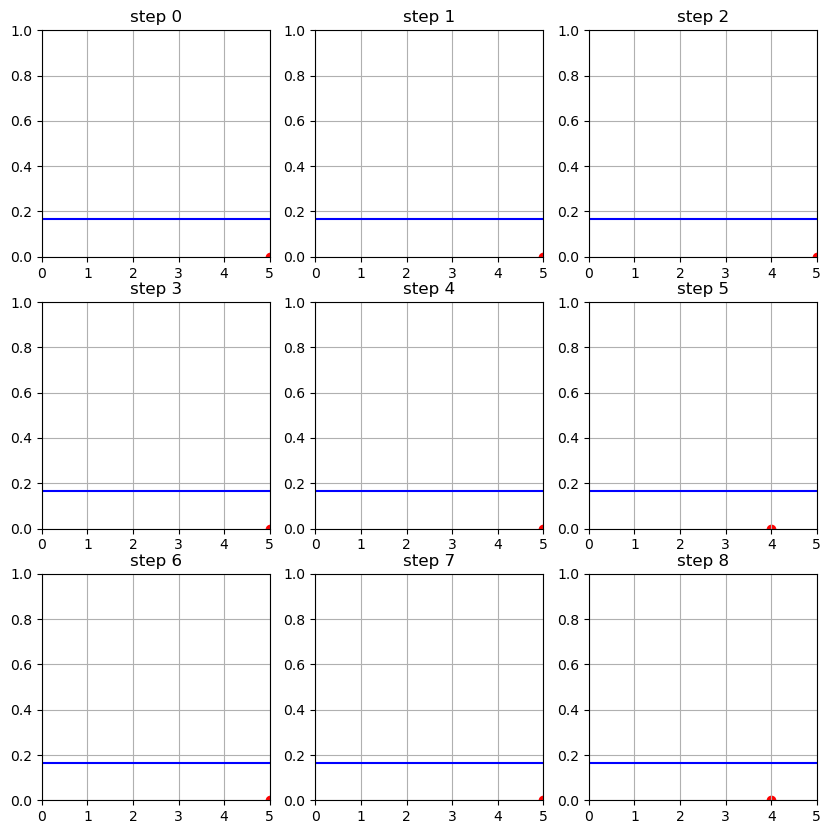

In [5]:
def main():
    env = Environment(6)
    markov = Agent(env)
    AgentVizualizer(markov, num_steps=9)()


if __name__ == '__main__':
    main()

# Beispielergebnis:

![markov](markov-example.png)